In [2]:
# Importing libraries and loading datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Loading datasets
root_path = '/kaggle/input/brazilian-ecommerce/'
customers_df = pd.read_csv(root_path + 'olist_customers_dataset.csv')
items_df = pd.read_csv(root_path + 'olist_order_items_dataset.csv')
payments_df = pd.read_csv(root_path + 'olist_order_payments_dataset.csv')
orders_df = pd.read_csv(root_path + 'olist_orders_dataset.csv')
products_df = pd.read_csv(root_path + 'olist_products_dataset.csv')
sellers_df = pd.read_csv(root_path + 'olist_sellers_dataset.csv')
categories_df = pd.read_csv(root_path + 'product_category_name_translation.csv')



In [3]:
# Merge product and category dataframes
products_df = pd.merge(products_df, categories_df, on='product_category_name', how='left')
products_df.drop('product_category_name', axis=1, inplace=True)
products_df.rename(columns={'product_category_name_english': 'product_category'}, inplace=True)

In [4]:
# Check the number of unique customers and orders
unique_customers = customers_df['customer_unique_id'].nunique()
total_orders = orders_df['order_id'].nunique()
print(f"Unique customers: {unique_customers}")
print(f"Total orders: {total_orders}")
print(f"Orders per customer: {total_orders / unique_customers:.2f}")

Unique customers: 96096
Total orders: 99441
Orders per customer: 1.03


In [5]:
# Merging all the datasets
merged_df = pd.merge(orders_df, customers_df, on='customer_id')
merged_df = pd.merge(merged_df, items_df, on='order_id')
merged_df = pd.merge(merged_df, payments_df, on='order_id')
merged_df = pd.merge(merged_df, products_df, on='product_id')
merged_df = pd.merge(merged_df, sellers_df, on='seller_id')



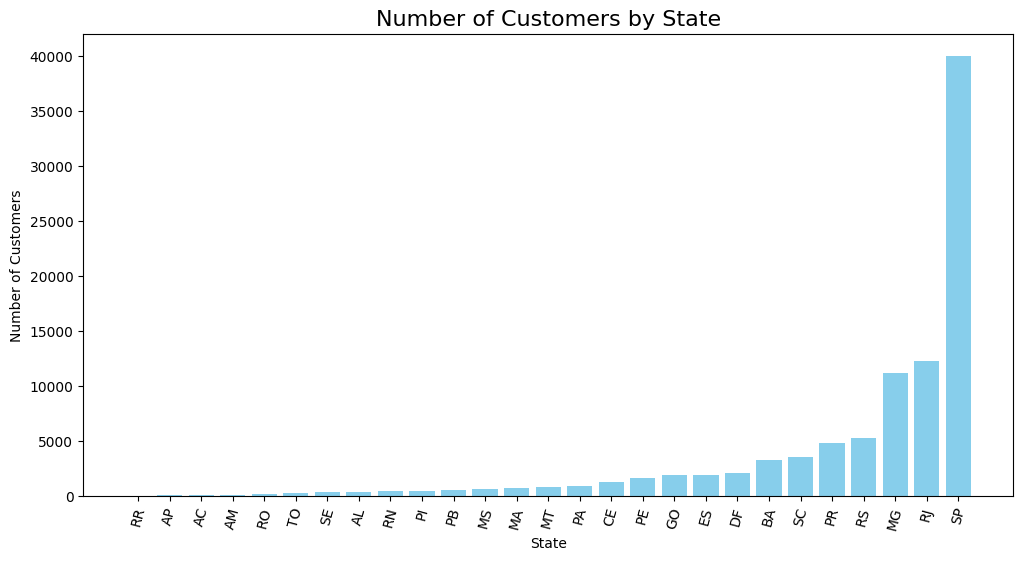

In [6]:
# Visualization: Number of customers by state
customers_per_state = merged_df.groupby('customer_state')['customer_unique_id'].nunique().reset_index()
customers_per_state = customers_per_state.sort_values('customer_unique_id')

plt.figure(figsize=(12, 6))
plt.bar(customers_per_state['customer_state'], customers_per_state['customer_unique_id'], color='skyblue')
plt.title('Number of Customers by State', fontsize=16)
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.xticks(rotation=75)
plt.show()


In [8]:
# Adding date-related columns for further analysis
merged_df['order_purchase_year'] = pd.to_datetime(merged_df['order_purchase_timestamp']).dt.year
merged_df['order_purchase_month'] = pd.to_datetime(merged_df['order_purchase_timestamp']).dt.month



In [9]:
# Data preparation for clustering
features = ['order_status', 'customer_state', 'order_item_id', 'price', 'freight_value', 'payment_sequential', 'payment_type', 
            'payment_installments', 'payment_value', 'order_purchase_year', 'order_purchase_month']

data_for_clustering = merged_df[features]


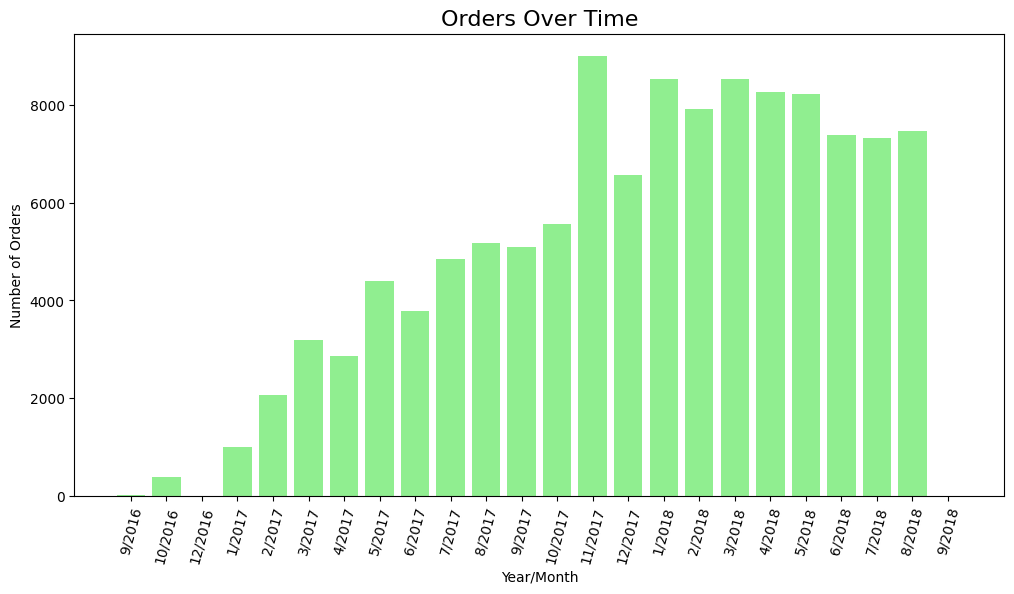

In [10]:

# Visualization: Number of orders per year and month
orders_per_period = merged_df.groupby(['order_purchase_year', 'order_purchase_month'])['order_id'].count().reset_index()
orders_per_period['period'] = orders_per_period['order_purchase_month'].astype(str) + '/' + orders_per_period['order_purchase_year'].astype(str)

plt.figure(figsize=(12, 6))
plt.bar(orders_per_period['period'], orders_per_period['order_id'], color='lightgreen')
plt.title('Orders Over Time', fontsize=16)
plt.xticks(rotation=75)
plt.xlabel('Year/Month')
plt.ylabel('Number of Orders')
plt.show()


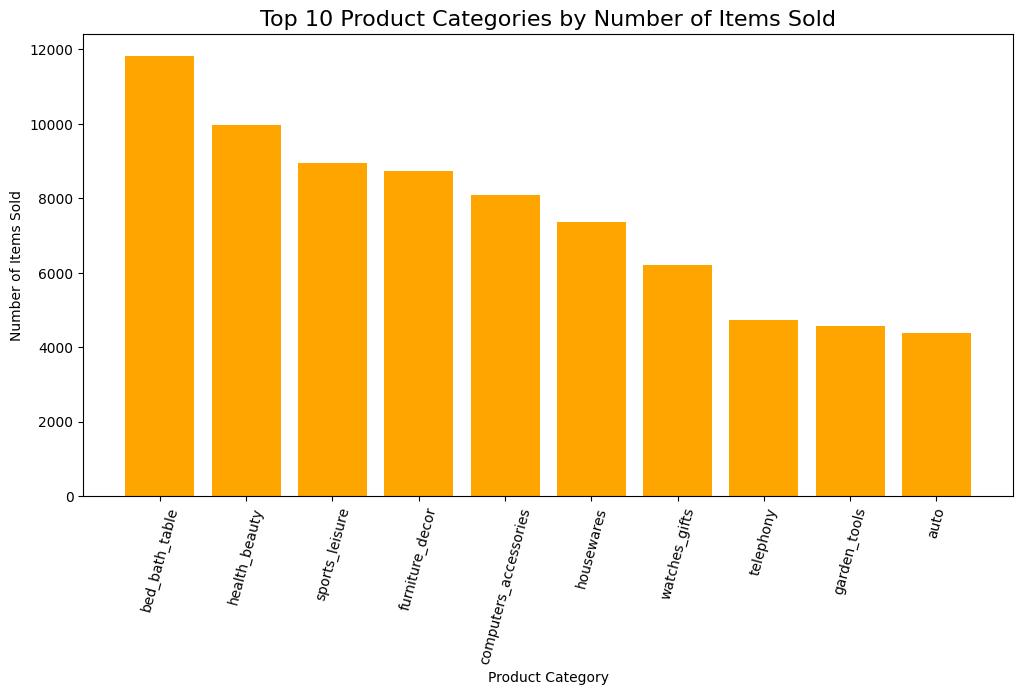

In [11]:
# Top 10 product categories by number of items sold
top_categories = merged_df.groupby('product_category')['order_item_id'].count().reset_index().sort_values('order_item_id', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(top_categories['product_category'][:10], top_categories['order_item_id'][:10], color='orange')
plt.title('Top 10 Product Categories by Number of Items Sold', fontsize=16)
plt.xticks(rotation=75)
plt.xlabel('Product Category')
plt.ylabel('Number of Items Sold')
plt.show()


In [16]:
# Preprocessing pipeline for numerical and categorical attributes
num_cols = ['order_item_id', 'price', 'freight_value', 'payment_sequential', 'payment_installments', 'payment_value', 
            'order_purchase_year', 'order_purchase_month']
cat_cols = ['order_status', 'customer_state', 'payment_type']

full_pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(), cat_cols)
])

prepared_data = full_pipeline.fit_transform(data_for_clustering)
prepared_data=prepared_data.toarray()

In [17]:

# Dimensionality reduction using PCA
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(prepared_data)

In [18]:


# Finding optimal number of clusters using inertia and silhouette score
inertia_values = []
silhouette_scores = []
k_values = range(2, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(reduced_data, kmeans.labels_))

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

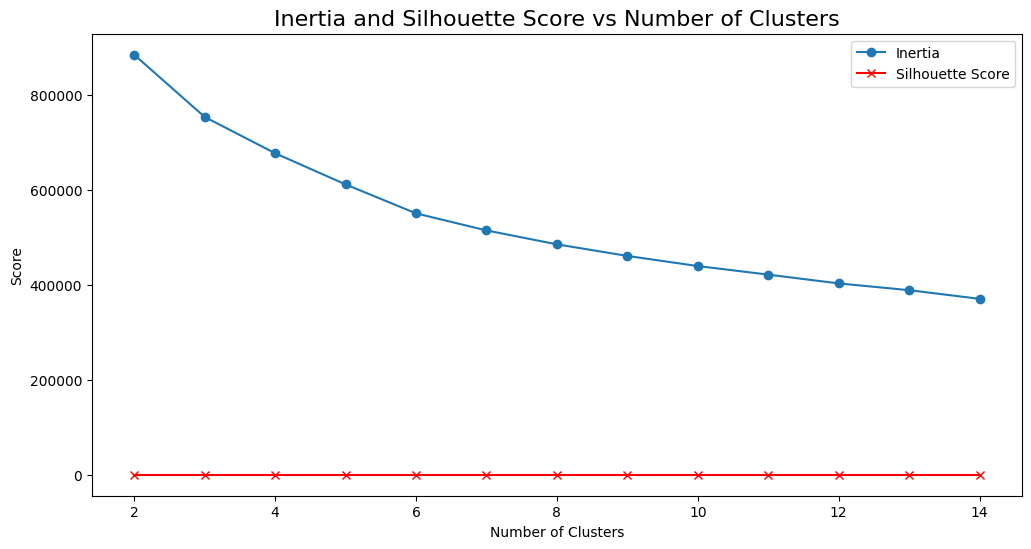

In [19]:



# Plotting inertia and silhouette scores to determine optimal number of clusters
plt.figure(figsize=(12, 6))
plt.plot(k_values, inertia_values, marker='o', label='Inertia')
plt.plot(k_values, silhouette_scores, marker='x', label='Silhouette Score', color='red')
plt.title('Inertia and Silhouette Score vs Number of Clusters', fontsize=16)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

In [20]:

# Choosing the best number of clusters and applying KMeans
best_k = k_values[np.argmax(silhouette_scores)]
print(f'Best number of clusters: {best_k}')

final_kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = final_kmeans.fit_predict(reduced_data)

Best number of clusters: 7


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [21]:


# Displaying the number of customers in each cluster
for i in range(best_k):
    print(f"Cluster {i + 1}: {np.sum(cluster_labels == i)} customers")

Cluster 1: 50108 customers
Cluster 2: 3996 customers
Cluster 3: 1145 customers
Cluster 4: 41682 customers
Cluster 5: 526 customers
Cluster 6: 15168 customers
Cluster 7: 4976 customers


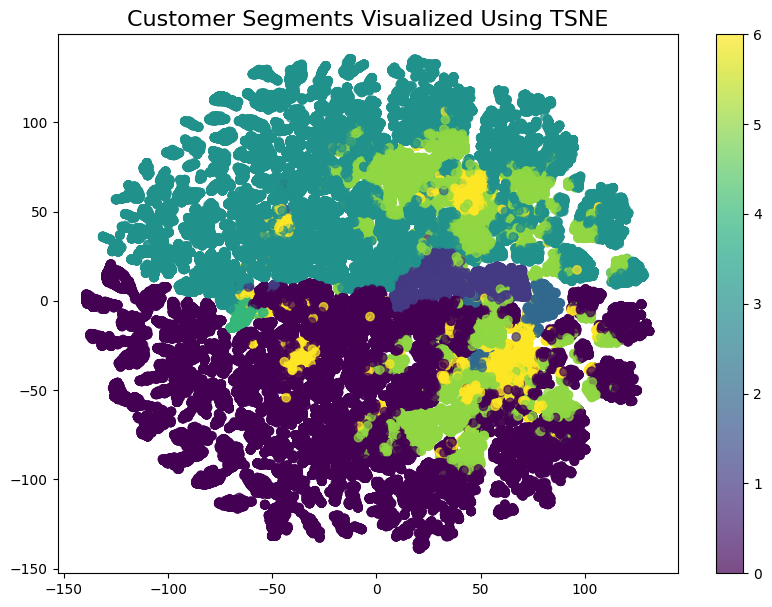

In [22]:


# Visualization: Clustering result using TSNE for 2D projection
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(prepared_data)

plt.figure(figsize=(10, 7))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title('Customer Segments Visualized Using TSNE', fontsize=16)
plt.colorbar()
plt.show()
